In [33]:
# Instala a biblioteca OR-Tools para Programação com Restrições
%pip install ortools

Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from ortools.sat.python import cp_model
from datetime import datetime, timedelta

In [35]:
class TaskScheduler:
    """Classe para resolver problemas de agendamento de tarefas usando OR-Tools."""
    
    def __init__(self, n_tasks, n_machines, n_slots):
        self.n_tasks = n_tasks
        self.n_machines = n_machines
        self.n_slots = n_slots
        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()
        
        # Variáveis de decisão mais simples
        self.task_assignments = {}
        self._create_variables()
    
    def _create_variables(self):
        """Cria variáveis de decisão: uma variável booleana para cada (tarefa, slot, máquina)."""
        for t in range(self.n_tasks):
            for s in range(self.n_slots):
                for m in range(self.n_machines):
                    self.task_assignments[(t, s, m)] = self.model.NewBoolVar(f'task_{t}_slot_{s}_machine_{m}')
    
    def add_basic_constraints(self):
        """Adiciona restrições básicas do problema."""
        # 1. Cada tarefa deve ser executada exatamente uma vez
        for t in range(self.n_tasks):
            self.model.Add(
                sum(self.task_assignments[(t, s, m)] 
                    for s in range(self.n_slots) 
                    for m in range(self.n_machines)) == 1
            )
        
        # 2. Cada máquina pode executar no máximo uma tarefa por slot
        for s in range(self.n_slots):
            for m in range(self.n_machines):
                self.model.Add(
                    sum(self.task_assignments[(t, s, m)] 
                        for t in range(self.n_tasks)) <= 1
                )
    
    def add_fixed_task_constraint(self, task_id, slot_id, machine_id=None):
        """Fixa uma tarefa específica em um slot e opcionalmente em uma máquina."""
        if machine_id is not None:
            # Fixa tarefa em slot e máquina específicos
            self.model.Add(self.task_assignments[(task_id, slot_id, machine_id)] == 1)
        else:
            # Fixa tarefa apenas no slot (qualquer máquina)
            self.model.Add(
                sum(self.task_assignments[(task_id, slot_id, m)] 
                    for m in range(self.n_machines)) == 1
            )
    
    def add_precedence_constraint(self, task_before, task_after):
        """Adiciona restrição de precedência: task_before deve terminar antes de task_after começar."""
        # Calcula o slot de cada tarefa
        slot_before = sum(s * self.task_assignments[(task_before, s, m)]
                         for s in range(self.n_slots)
                         for m in range(self.n_machines))
        
        slot_after = sum(s * self.task_assignments[(task_after, s, m)]
                        for s in range(self.n_slots)
                        for m in range(self.n_machines))
        
        self.model.Add(slot_before < slot_after)
    
    def add_machine_preference(self, task_id, preferred_machine, bonus_weight=1):
        """Adiciona preferência de máquina (usado na função objetivo)."""
        if not hasattr(self, 'preferences'):
            self.preferences = []
        
        preference_bonus = sum(self.task_assignments[(task_id, s, preferred_machine)]
                              for s in range(self.n_slots))
        self.preferences.append(bonus_weight * preference_bonus)
    
    def set_objective_minimize_makespan(self):
        """Define objetivo para minimizar o makespan (tempo total)."""
        # Variável para o makespan
        makespan = self.model.NewIntVar(0, self.n_slots - 1, 'makespan')
        
        # Makespan deve ser pelo menos o slot máximo usado
        for t in range(self.n_tasks):
            task_slot = sum(s * self.task_assignments[(t, s, m)]
                           for s in range(self.n_slots)
                           for m in range(self.n_machines))
            self.model.Add(makespan >= task_slot)
        
        self.model.Minimize(makespan)
    
    def set_objective_balance_load(self):
        """Define objetivo para balancear carga entre máquinas."""
        # Calcula carga por máquina
        machine_loads = []
        for m in range(self.n_machines):
            load = sum(self.task_assignments[(t, s, m)]
                      for t in range(self.n_tasks)
                      for s in range(self.n_slots))
            machine_loads.append(load)
        
        # Minimiza a diferença máxima entre cargas
        max_load = self.model.NewIntVar(0, self.n_tasks, 'max_load')
        min_load = self.model.NewIntVar(0, self.n_tasks, 'min_load')
        
        for load in machine_loads:
            self.model.Add(max_load >= load)
            self.model.Add(min_load <= load)
        
        self.model.Minimize(max_load - min_load)
    
    def solve(self, time_limit_seconds=10):
        """Resolve o problema de agendamento."""
        # Configura solver
        self.solver.parameters.max_time_in_seconds = time_limit_seconds
        self.solver.parameters.log_search_progress = False
        
        # Resolve
        status = self.solver.Solve(self.model)
        
        if status in [cp_model.FEASIBLE, cp_model.OPTIMAL]:
            return self._extract_solution(status)
        else:
            return None
    
    def _extract_solution(self, status):
        """Extrai a solução do solver."""
        schedule = []
        machine_loads = [0] * self.n_machines
        
        for t in range(self.n_tasks):
            for s in range(self.n_slots):
                for m in range(self.n_machines):
                    if self.solver.Value(self.task_assignments[(t, s, m)]):
                        schedule.append({
                            'Task': f'Tarefa {t}',
                            'Task_ID': t,
                            'Slot': s,
                            'Machine': f'Máquina {m}',
                            'Machine_ID': m
                        })
                        machine_loads[m] += 1
                        break
        
        return {
            'schedule': pd.DataFrame(schedule).sort_values(['Slot', 'Machine_ID']),
            'machine_loads': machine_loads,
            'objective_value': self.solver.ObjectiveValue() if self.solver.ObjectiveValue() else 0,
            'solve_time': self.solver.WallTime(),
            'status': 'OPTIMAL' if status == cp_model.OPTIMAL else 'FEASIBLE'
        }

In [36]:
def create_gantt_chart(solution, task_names=None, save_path=None):
    """Cria gráfico de Gantt melhorado."""
    if solution is None:
        print("Não é possível criar gráfico: solução não encontrada")
        return
    
    schedule_df = solution['schedule']
    
    # Configura o gráfico
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Gráfico 1: Gantt Chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(schedule_df['Machine_ID'].unique())))
    machine_colors = {mid: colors[i] for i, mid in enumerate(sorted(schedule_df['Machine_ID'].unique()))}
    
    for idx, row in schedule_df.iterrows():
        task_name = task_names[row['Task_ID']] if task_names else row['Task']
        color = machine_colors[row['Machine_ID']]
        
        ax1.barh(row['Task'], width=0.8, left=row['Slot'], 
                color=color, edgecolor='black', alpha=0.7)
        
        # Adiciona texto no centro da barra
        ax1.text(row['Slot'] + 0.4, idx, f"M{row['Machine_ID']}", 
                ha='center', va='center', fontweight='bold', fontsize=9)
    
    ax1.set_xlabel('Slots de Tempo')
    ax1.set_ylabel('Tarefas')
    ax1.set_title('Cronograma de Tarefas - Gráfico de Gantt')
    ax1.grid(True, axis='x', alpha=0.3)
    
    # Legenda
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=machine_colors[mid], 
                                   label=f'Máquina {mid}') 
                      for mid in sorted(machine_colors.keys())]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Gráfico 2: Carga por máquina
    machine_ids = sorted(schedule_df['Machine_ID'].unique())
    loads = [solution['machine_loads'][mid] for mid in machine_ids]
    machine_labels = [f'Máquina {mid}' for mid in machine_ids]
    
    bars = ax2.bar(machine_labels, loads, color=[machine_colors[mid] for mid in machine_ids], 
                   alpha=0.7, edgecolor='black')
    
    # Adiciona valores nas barras
    for bar, load in zip(bars, loads):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{load}', ha='center', va='center', fontweight='bold')
    
    ax2.set_ylabel('Número de Tarefas')
    ax2.set_title('Distribuição de Carga por Máquina')
    ax2.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [37]:
def print_solution_summary(solution):
    """Imprime resumo da solução."""
    if solution is None:
        print("❌ Nenhuma solução encontrada")
        return
    
    print("="*60)
    print("RESUMO DA SOLUÇÃO DE AGENDAMENTO")
    print("="*60)
    print(f"✅ Status: {solution['status']}")
    print(f"🎯 Valor objetivo: {solution['objective_value']}")
    print(f"⏱️  Tempo de solução: {solution['solve_time']:.3f}s")
    print()
    
    print("📋 CRONOGRAMA DETALHADO:")
    print(solution['schedule'].to_string(index=False))
    print()
    
    print("📊 CARGA POR MÁQUINA:")
    for i, load in enumerate(solution['machine_loads']):
        print(f"  Máquina {i}: {load} tarefas")

In [38]:
# Exemplo de uso com contexto do dataset Iris
def solve_iris_analysis_scheduling():
    """Resolve agendamento de tarefas de análise do dataset Iris."""
    
    # Carrega dados do Iris para dar contexto às tarefas
    iris = load_iris()
    species_names = iris.target_names
    
    # Define tarefas baseadas em análises reais do Iris
    task_descriptions = [
        "Análise exploratória - Setosa",
        "Análise exploratória - Versicolor", 
        "Análise exploratória - Virginica",
        "Modelagem preditiva",
        "Validação do modelo",
        "Relatório final"
    ]
    
    print("🌸 AGENDAMENTO DE ANÁLISES DO DATASET IRIS")
    print("Tarefas a serem agendadas:")
    for i, desc in enumerate(task_descriptions):
        print(f"  Tarefa {i}: {desc}")
    print()
    
    # Cria o scheduler
    scheduler = TaskScheduler(n_tasks=6, n_machines=2, n_slots=5)
    
    # Adiciona restrições básicas
    scheduler.add_basic_constraints()
    
    # Restrições específicas do domínio
    scheduler.add_fixed_task_constraint(0, 0)  # Análise setosa deve ser primeira
    scheduler.add_precedence_constraint(3, 4)  # Modelagem antes da validação
    scheduler.add_precedence_constraint(4, 5)  # Validação antes do relatório
    
    # Preferências de máquina (máquina 0 é melhor para análises exploratórias)
    for i in range(3):  # Primeiras 3 tarefas são análises exploratórias
        scheduler.add_machine_preference(i, 0, bonus_weight=1)
    
    # Define objetivo: minimizar makespan
    scheduler.set_objective_minimize_makespan()
    
    # Resolve
    print("🔄 Resolvendo problema de agendamento...")
    solution = scheduler.solve(time_limit_seconds=30)
    
    if solution:
        print_solution_summary(solution)
        create_gantt_chart(solution, task_names=task_descriptions)
        
        # Análise adicional
        print("\n🔍 ANÁLISE ADICIONAL:")
        df = solution['schedule']
        
        # Utilização por slot
        slot_usage = df.groupby('Slot').size()
        print("Utilização por slot:")
        for slot, count in slot_usage.items():
            print(f"  Slot {slot}: {count} tarefas")
        
        # Verifica se há slots vazios
        empty_slots = set(range(5)) - set(slot_usage.index)
        if empty_slots:
            print(f"  Slots vazios: {sorted(empty_slots)}")
        
        return solution
    else:
        print("❌ Não foi possível encontrar uma solução viável")
        return None

🌸 AGENDAMENTO DE ANÁLISES DO DATASET IRIS
Tarefas a serem agendadas:
  Tarefa 0: Análise exploratória - Setosa
  Tarefa 1: Análise exploratória - Versicolor
  Tarefa 2: Análise exploratória - Virginica
  Tarefa 3: Modelagem preditiva
  Tarefa 4: Validação do modelo
  Tarefa 5: Relatório final

🔄 Resolvendo problema de agendamento...


RESUMO DA SOLUÇÃO DE AGENDAMENTO
✅ Status: OPTIMAL
🎯 Valor objetivo: 2.0
⏱️  Tempo de solução: 0.009s

📋 CRONOGRAMA DETALHADO:
    Task  Task_ID  Slot   Machine  Machine_ID
Tarefa 0        0     0 Máquina 0           0
Tarefa 3        3     0 Máquina 1           1
Tarefa 1        1     1 Máquina 0           0
Tarefa 4        4     1 Máquina 1           1
Tarefa 5        5     2 Máquina 0           0
Tarefa 2        2     2 Máquina 1           1

📊 CARGA POR MÁQUINA:
  Máquina 0: 3 tarefas
  Máquina 1: 3 tarefas


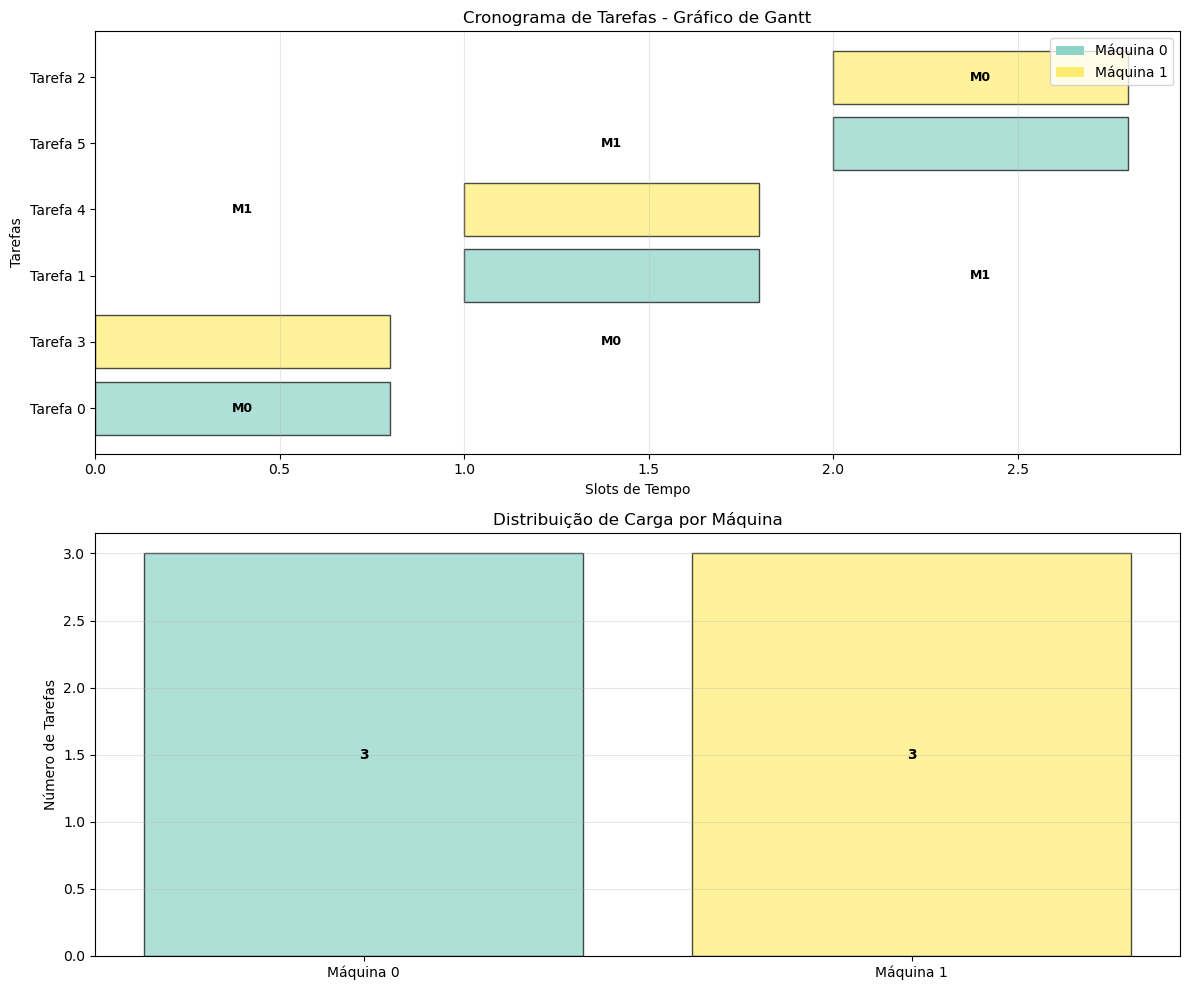


🔍 ANÁLISE ADICIONAL:
Utilização por slot:
  Slot 0: 2 tarefas
  Slot 1: 2 tarefas
  Slot 2: 2 tarefas
  Slots vazios: [3, 4]


In [39]:
solution = solve_iris_analysis_scheduling()